# Installing Kaggle to download the dataset

In [ ]:
!pip install kaggle

In [ ]:
#getting data from kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:38<00:00, 19.7MB/s]
100% 812M/812M [00:38<00:00, 22.3MB/s]


In [ ]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

# Importing the Libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import pandas as pd
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Flatten,MaxPooling2D
from tensorflow.keras.applications import DenseNet201 as densenet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Making the required directories for the transfer learning

Dataset Structure

train folder


*   Cat
*   Dog


test folder

*   Cat
*   Dog

train test split is **80-20**



In [ ]:
os.makedirs("train/cat",exist_ok=True)
os.makedirs("train/dog",exist_ok=True)

In [ ]:
dst_path_cat = "train/cat"
dst_path_dog = "train/dog"
source_path = "train"

In [ ]:
import shutil
for file in os.listdir(source_path):
  if file[0:3] == "cat" and file[-3:] == "jpg":
    shutil.move(os.path.join(source_path,file),os.path.join(dst_path_cat,file))
  if file[0:3] == "dog" and file[-3:] == "jpg":
    shutil.move(os.path.join(source_path,file),os.path.join(dst_path_dog,file))

In [ ]:
!mkdir test
os.makedirs("test/cat",exist_ok=True)
os.makedirs("test/dog",exist_ok=True)

In [ ]:
data_20 = int((0.2)*len(os.listdir("train/dog")))
type(data_20)

int

In [ ]:
test_src_dog = "test/dog"
test_src_cat = "test/cat"
for file in os.listdir("train/dog")[-data_20:]:
  shutil.move(os.path.join("train/dog",file),os.path.join(test_src_dog,file))
for file in os.listdir("train/cat")[-data_20:]:
  shutil.move(os.path.join("train/cat",file),os.path.join(test_src_cat,file))



In [ ]:
print(f"No of images in train directory {2*len(os.listdir('train/cat'))} No of Cats {len(os.listdir('train/cat'))} No of Dogs {len(os.listdir('train/dog'))}")
print(f"No of images in test directory {2*len(os.listdir('test/cat'))} No of Cats {len(os.listdir('test/cat'))} No of Dogs {len(os.listdir('test/dog'))}")

No of images in train directory 20000 No of Cats 10000 No of Dogs 10000
No of images in test directory 5000 No of Cats 2500 No of Dogs 2500


# Data Augmentation

In [ ]:
##Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_dataset = train_datagen.flow_from_directory(
    'train',
    target_size=(100, 100),
    batch_size=32,
    class_mode='binary'
)
test_dataset = test_datagen.flow_from_directory(
    'test',
    target_size=(100, 100),
    batch_size=32,
    class_mode='binary'
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Model Training

In [ ]:
dn = densenet(weights='imagenet',include_top=False,input_shape=(100,100,3))
dn.trainable = False
i = Input(shape=(100,100,3))
x = dn(i)
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(1,activation='linear',kernel_regularizer=l2(0.01))(x)
model = Model(i,x)
model.summary()


74836368/74836368 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 3, 3, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 17280)             0         
                                                                 
 dense (Dense)               (None, 128)               2211968   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                              

In [ ]:
model.compile(optimizer=Adam(),loss='hinge',metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // train_dataset.batch_size,
    validation_data=test_dataset,
    validation_steps=test_dataset.samples // test_dataset.batch_size,
    epochs=10)

Epoch 1/10
625/625 [==============================] - 129s 175ms/step - loss: 0.2606 - accuracy: 0.9086 - val_loss: 0.1572 - val_accuracy: 0.9343
Epoch 2/10
625/625 [==============================] - 102s 164ms/step - loss: 0.1827 - accuracy: 0.9260 - val_loss: 0.1537 - val_accuracy: 0.9383
Epoch 3/10
625/625 [==============================] - 103s 165ms/step - loss: 0.1641 - accuracy: 0.9317 - val_loss: 0.1374 - val_accuracy: 0.9401
Epoch 4/10
625/625 [==============================] - 103s 164ms/step - loss: 0.1547 - accuracy: 0.9337 - val_loss: 0.1324 - val_accuracy: 0.9425
Epoch 5/10
625/625 [==============================] - 103s 165ms/step - loss: 0.1535 - accuracy: 0.9340 - val_loss: 0.1352 - val_accuracy: 0.9351
Epoch 6/10
625/625 [==============================] - 103s 165ms/step - loss: 0.1483 - accuracy: 0.9360 - val_loss: 0.1501 - val_accuracy: 0.9381
Epoch 7/10
625/625 [==============================] - 104s 166ms/step - loss: 0.1417 - accuracy: 0.9389 - val_loss: 0.1455 -

# Plotting model loss and accuracies

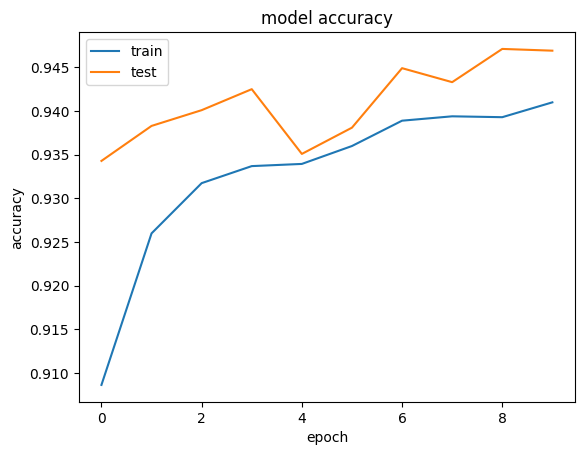

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

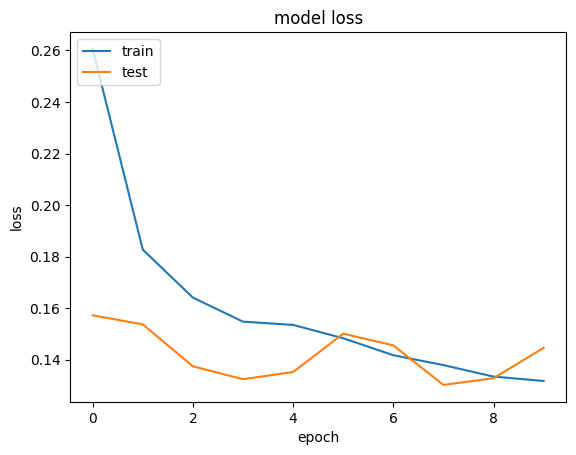

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Saving the model
Our Model gives 94% accuracy

In [ ]:
model.save('catsvdogs_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing random images

In [ ]:
from tensorflow.keras.preprocessing import image
def preprocess_and_evaluate(img):
  img = image.load_img(img,target_size=(100,100))
  img = image.img_to_array(img)
  img = img/255.0
  img = np.expand_dims(img,axis=0)
  y_pred = model.predict(img)
  if y_pred>0:
    return "Dog"
  if y_pred<0:
    return "Cat"
  return y_pred

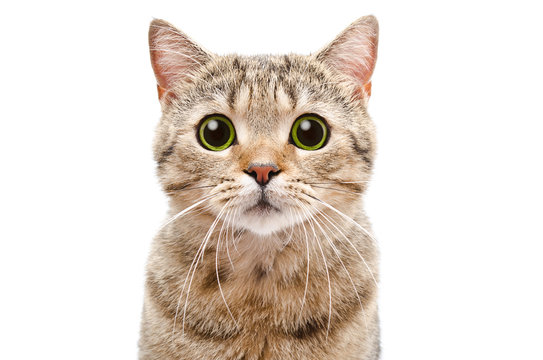

In [ ]:
from PIL import Image
Image.open("cat.jpg")

In [ ]:
preprocess_and_evaluate('cat.jpg')

1/1 [==============================] - 0s 35ms/step


'Cat'

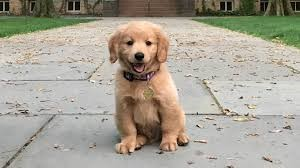

In [ ]:
Image.open("dog.jpg")

In [ ]:
preprocess_and_evaluate("dog.jpg")

1/1 [==============================] - 0s 62ms/step


'Dog'

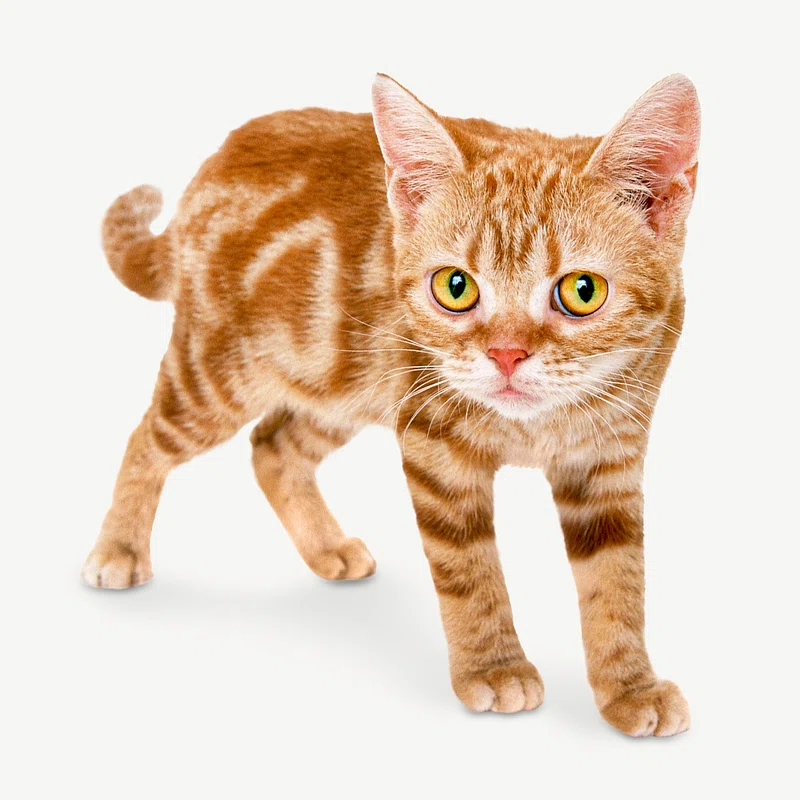

In [ ]:
Image.open("car.webp")

In [ ]:
preprocess_and_evaluate("car.webp")

1/1 [==============================] - 0s 38ms/step


'Cat'

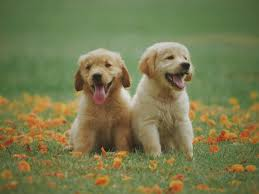

In [ ]:
Image.open("2dogs.jfif")

In [ ]:
preprocess_and_evaluate("2dogs.jfif")

1/1 [==============================] - 0s 181ms/step


'Dog'